# Programming Task: Probabilistic Inference

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import loggamma
%matplotlib inline  

## Your task
This notebook contains code implementing the methods discussed in `Lecture 3: Probabilistic Inference`. Some functions in this notebook are incomplete. Your task is to fill in the missing code and run the entire notebook. 

In the beginning of every function there is docstring which specifies the input and and expected output.
Write your code in a way that adheres to it.
You may only use plain python and anything that we imported for you above such as `numpy` functions (i.e. no scikit-learn classifiers).

## Simulating data
The following function simulates flipping a biased coin. 

In [10]:
# This function is given, nothing to do here.
def simulate_data(num_samples, tails_proba):
    """Simulate a sequence of i.i.d. coin flips.
    
    Tails are denoted as 1 and heads are denoted as 0.
    
    Parameters
    ----------
    num_samples : int
        Number of samples to generate.
    tails_proba : float in range (0, 1)
        Probability of observing tails.
    
    Returns
    -------
    samples : array, shape (num_samples)
        Outcomes of simulated coin flips. Tails is 1 and heads is 0.
    """
    return np.random.choice([0, 1], size=(num_samples), p=[1 - tails_proba, tails_proba])

In [11]:
np.random.seed(123)  # for reproducibility
num_samples = 20
tails_proba = 0.7
samples = simulate_data(num_samples, tails_proba)
print(samples)

[1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]


# Important: Numerical stability
When dealing with probabilities, we often encounter extremely small numbers. Because of limited floating point precision, directly manipulating such small numbers can lead to serious numerical issues, such as overflows and underflows. Therefore, we usually work in the **log-space**.

For example, if we want to multiply two tiny numbers $a$ and $b$, we should compute $\exp(\log(a) + \log(b))$ instead of naively multiplying $a \cdot b$.

For this reason, we usually compute **log-probabilities** instead of **probabilities**. Virtually all machine learning libraries are dealing with log-probabilities instead of probabilities (e.g. [Tensorflow-probability](https://www.tensorflow.org/probability) or [Pyro](https://pyro.ai)).

## Task 1: Compute $\log p(\mathcal{D} \mid \theta)$ for different values of $\theta$

In [12]:
def compute_log_likelihood(theta, samples):
    """Compute log p(D | theta) for the given values of theta.
    
    Parameters
    ----------
    theta : array, shape (num_points)
        Values of theta for which it's necessary to evaluate the log-likelihood.
    samples : array, shape (num_samples)
        Outcomes of simulated coin flips. Tails is 1 and heads is 0.
    
    Returns
    -------
    log_likelihood : array, shape (num_points)
        Values of log-likelihood for each value in theta.
    """
    ### YOUR CODE HERE ###
    f1 = np.sum(samples)
    f0 = len(samples) - f1
    return f1 * np.log(theta) + f0 * np.log(1-theta)
    

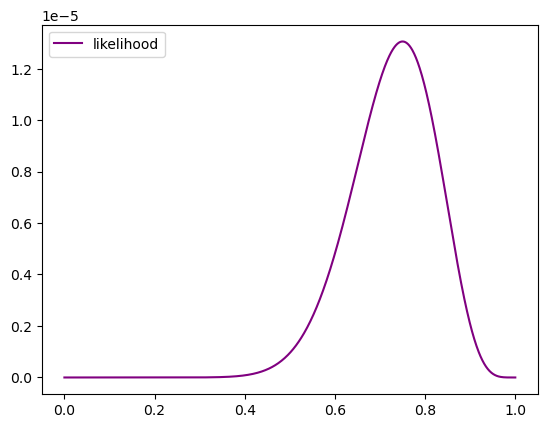

In [13]:
x = np.linspace(1e-5, 1-1e-5, 1000)
log_likelihood = compute_log_likelihood(x, samples)
likelihood = np.exp(log_likelihood)
plt.plot(x, likelihood, label='likelihood', c='purple')
plt.legend()

Note that the likelihood function doesn't define a probability distribution over $\theta$ --- the integral $\int_{0}^{1} p(\mathcal{D} \mid \theta) d\theta$ is not equal to one.

To show this, we approximate $\int_{0}^{1} p(\mathcal{D} \mid \theta) d\theta$ numerically using [the rectangle rule](https://en.wikipedia.org/wiki/Riemann_sum).

In [14]:
# 1.0 is the length of the interval over which we are integrating p(D | theta)
int_likelihood = 1.0 * np.mean(likelihood)
print(f'Integral = {int_likelihood:.4}')

Integral = 3.068e-06


## Task 2: Compute $\log p(\theta \mid a, b)$ for different values of $\theta$
The function `loggamma` from the `scipy.special` package might be useful here. (It's already imported - see the first cell)

In [15]:
def compute_log_prior(theta, a, b):
    """Compute log p(theta | a, b) for the given values of theta.
    
    Parameters
    ----------
    theta : array, shape (num_points)
        Values of theta for which it's necessary to evaluate the log-prior.
    a, b: float
        Parameters of the prior Beta distribution.
    
    Returns
    -------
    log_prior : array, shape (num_points)
        Values of log-prior for each value in theta.
    
    """
    ### YOUR CODE HERE ###
    return (loggamma(a+b) - loggamma(a) - loggamma(b)) + (a-1) * np.log(theta) + (b-1) * np.log(1- theta)

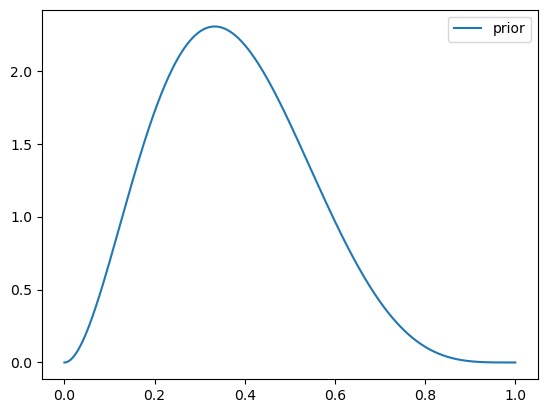

In [16]:
x = np.linspace(1e-5, 1-1e-5, 1000)
a, b = 3, 5

# Plot the prior distribution
log_prior = compute_log_prior(x, a, b)
prior = np.exp(log_prior)
plt.plot(x, prior, label='prior')
plt.legend()

Unlike the likelihood, the prior defines a probability distribution over $\theta$ and integrates to 1.

In [17]:
int_prior = 1.0 * np.mean(prior)
print(f'Integral = {int_prior:.4}')

Integral = 0.999


## Task 3: Compute $\log p(\theta \mid \mathcal{D}, a, b)$ for different values of $\theta$
The function `loggamma` from the `scipy.special` package might be useful here.

In [18]:
def compute_log_posterior(theta, samples, a, b):
    """Compute log p(theta | D, a, b) for the given values of theta.
    
    Parameters
    ----------
    theta : array, shape (num_points)
        Values of theta for which it's necessary to evaluate the log-prior.
    samples : array, shape (num_samples)
        Outcomes of simulated coin flips. Tails is 1 and heads is 0.
    a, b: float
        Parameters of the prior Beta distribution.
    
    Returns
    -------
    log_posterior : array, shape (num_points)
        Values of log-posterior for each value in theta.
    """
    ### YOUR CODE HERE ###
    f1 = np.sum(samples)
    f0 = len(samples) - f1
    return compute_log_prior(theta, a + f1, b + f0)

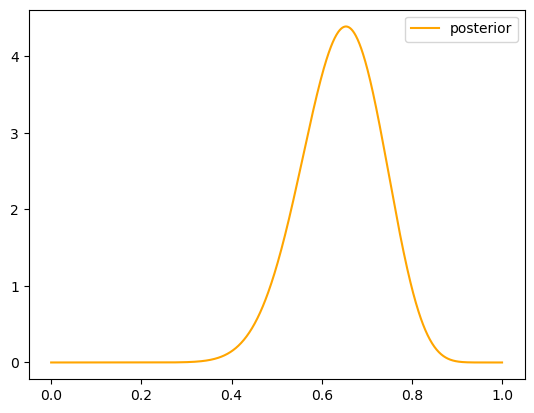

In [19]:
x = np.linspace(1e-5, 1-1e-5, 1000)

log_posterior = compute_log_posterior(x, samples, a, b)
posterior = np.exp(log_posterior)
plt.plot(x, posterior, label='posterior', c='orange')
plt.legend()

Like the prior, the posterior defines a probability distribution over $\theta$ and integrates to 1.

In [20]:
int_posterior = 1.0 * np.mean(posterior)
print(f'Integral = {int_posterior:.4}')

Integral = 0.999


## Task 4: Compute $\theta_{MLE}$

In [21]:
def compute_theta_mle(samples):
    """Compute theta_MLE for the given data.
    
    Parameters
    ----------
    samples : array, shape (num_samples)
        Outcomes of simulated coin flips. Tails is 1 and heads is 0.
    
    Returns
    -------
    theta_mle : float
        Maximum likelihood estimate of theta.
    """
    ### YOUR CODE HERE ###
    f1 = np.sum(samples)
    f0 = len(samples) - f1
    return f1/(f1+f0)

In [22]:
theta_mle = compute_theta_mle(samples)
print(f'theta_mle = {theta_mle:.3f}')

theta_mle = 0.750


## Task 5: Compute $\theta_{MAP}$

In [23]:
def compute_theta_map(samples, a, b):
    """Compute theta_MAP for the given data.
    
    Parameters
    ----------
    samples : array, shape (num_samples)
        Outcomes of simulated coin flips. Tails is 1 and heads is 0.
    a, b: float
        Parameters of the prior Beta distribution.
    
    Returns
    -------
    theta_mle : float
        Maximum a posteriori estimate of theta.
    """
    ### YOUR CODE HERE ###
    f1 = np.sum(samples)
    f0 = len(samples) - f1
    return (f1 + a - 1)/(f1+f0 + a + b - 2)

In [24]:
theta_map = compute_theta_map(samples, a, b)
print(f'theta_map = {theta_map:.3f}')

theta_map = 0.654


# Putting everything together

Now you can play around with the values of `a`, `b`, `num_samples` and `tails_proba` to see how the results are changing.

In [25]:
num_samples = 20
tails_proba = 0.7
samples = simulate_data(num_samples, tails_proba)
a, b = 3, 5
print(samples)

[1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1]


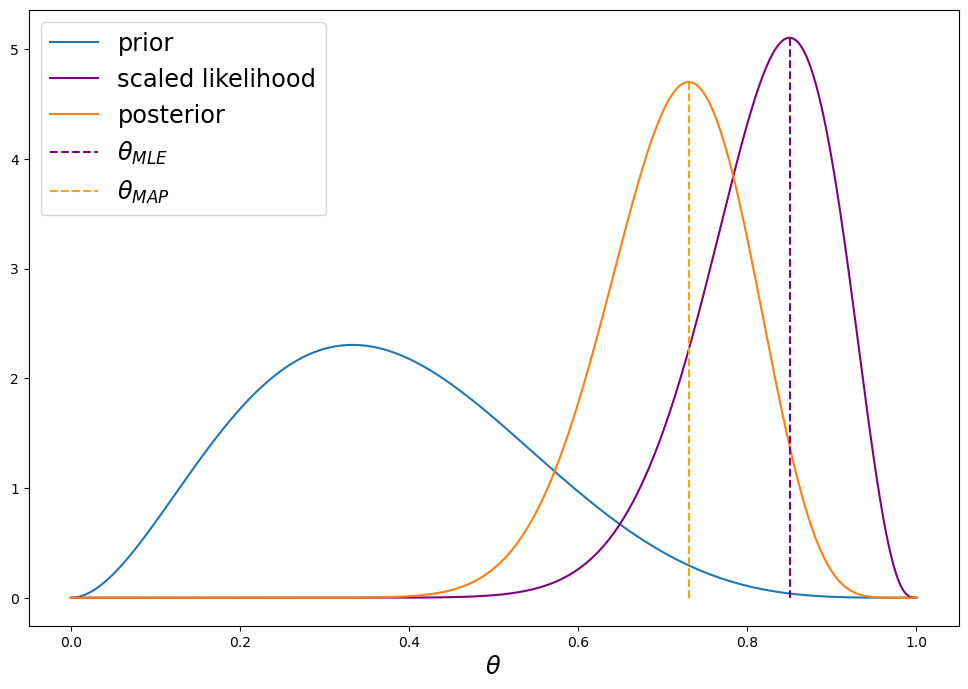

In [26]:
plt.figure(figsize=[12, 8])
x = np.linspace(1e-5, 1-1e-5, 1000)

# Plot the prior distribution
log_prior = compute_log_prior(x, a, b)
prior = np.exp(log_prior)
plt.plot(x, prior, label='prior')

# Plot the likelihood
log_likelihood = compute_log_likelihood(x, samples)
likelihood = np.exp(log_likelihood)
int_likelihood = np.mean(likelihood)
# We rescale the likelihood - otherwise it would be impossible to see in the plot
rescaled_likelihood = likelihood / int_likelihood
plt.plot(x, rescaled_likelihood, label='scaled likelihood', color='purple')

# Plot the posterior distribution
log_posterior = compute_log_posterior(x, samples, a, b)
posterior = np.exp(log_posterior)
plt.plot(x, posterior, label='posterior')

# Visualize theta_mle
theta_mle = compute_theta_mle(samples)
ymax = np.exp(compute_log_likelihood(np.array([theta_mle]), samples)) / int_likelihood
plt.vlines(x=theta_mle, ymin=0.00, ymax=ymax, linestyle='dashed', color='purple', label=r'$\theta_{MLE}$')


# Visualize theta_map
theta_map = compute_theta_map(samples, a, b)
ymax = np.exp(compute_log_posterior(np.array([theta_map]), samples, a, b))
plt.vlines(x=theta_map, ymin=0.00, ymax=ymax, linestyle='dashed', color='orange', label=r'$\theta_{MAP}$')

plt.xlabel(r'$\theta$', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()